In [1]:
particle_folder = '512positions/'
#filename1 = particle_folder+'Image_000450.npy'
#filename2 = particle_folder+'Image_000451.npy'
filename1 = particle_folder+'450.npy'
filename2 = particle_folder+'451.npy'
distance_threshold = 10
alpha = .004#.04 #512:.04 eher .04
startradius = 80 #40-100
endradius = 1
iterations = 5 #resized:5, 512:10
epsilon = 4

In [24]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist #in euclidean_distances?
import time
import numpy_indexed as npi #needed for index search in tracing feature

class SOM:
    def __init__(self, distance_threshold, alpha, startradius, endradius, iterations, epsilon):
        self.distance_threshold = distance_threshold
        self.alpha = alpha
        self.startradius = startradius
        self.endradius = endradius
        self.radius = startradius
        self.iterations = iterations
        self.epsilon = epsilon

    def read_in_coordinates(self,filename1, filename2): #reads in .npy files at filenames and enumerates 
        image1 = np.load(filename1)
        image1_ids = np.arange(len(image1))
        image1 = np.column_stack((image1,image1_ids))
        image2 = np.load(filename2)
        image2_ids = np.arange(len(image1),len(image1)+len(image2))
        image2 = np.column_stack((image2,image2_ids))
        return image1, image2

    def match_particles(self,coordinates_image1, coordinates_image2):
        
        coords1 = np.copy(coordinates_image1)
        coords2 = np.copy(coordinates_image2) 
        if len(coordinates_image1)>3 and len(coordinates_image2)>3:
            coordinates_image1, coordinates_image2 = self.iterated_weight_update(coordinates_image1, coordinates_image2)
            coordinates_image1, coordinates_image2 = self.particle_matching(coordinates_image1, coordinates_image2)
            coords2[:,2] = coordinates_image2[:,2]
        
        return coords1, coords2
    
    def euclidean_distances(self,image1, image2): #calculates distances from all particles in image1 to all particles in image2
        distances = cdist(image1[:, :2], image2[:, :2]) #calculates distances to all particles in image2 for all particles in image1
        return distances
    
    def euclidean_distance_and_bmu(self,image1, image2): #calculates nearest neighbor index and distance for every particle in image1 to particles in image2
        distances = cdist(image1[:, :2], image2[:, :2]) #calculates distances to all particles in image2 for all particles in image1
        nearest_indices = np.argmin(distances, axis=1) #finds the indices of nearest particles for all
        #nearest_coordinates = image2[nearest_indices] #gets the coordinates of nearest particles in image2
        nearest_distances = distances[np.arange(len(distances)),nearest_indices]
        nearest_distances[nearest_distances > self.distance_threshold] = 0
        nearest_indices = np.column_stack((nearest_indices,nearest_distances))
        return nearest_indices
        
    def weight_update_single_old(self,image1_weights, image2_weights): #updates weights in image1 using all particles of image2 as input
        best_matching_units = self.euclidean_distance_and_bmu(image2_weights, image1_weights)
        distances_in_image1 = self.euclidean_distances(image1_weights, image1_weights)
        bmu_distances_in_image1_on_all_inputs = distances_in_image1[best_matching_units[:,0].astype(int)] #distances of all particles in im1 to bmu of all inputs of im2
        which_particles_to_be_activated_by_all_inputs = (bmu_distances_in_image1_on_all_inputs < self.radius)*1 #comparison of distance to bmu to activation radius for all inputs
        bmu_coords_image1_input_wise = image1_weights[best_matching_units[:,0].astype(int), :2] #gives the bmu coords for each input to calculate the direction of weight delta
        distances_input_to_bmu_for_all_inputs = image2_weights[:,:2] - bmu_coords_image1_input_wise #xy distances of each input coord im2 - bmu coord im1 
        distances_input_to_bmu_for_all_inputs_alpha_product = distances_input_to_bmu_for_all_inputs * self.alpha #calculates the product of input-bmu distances abnd alpha
        x_direction_updates_for_all_inputs_in_activation_radius = distances_input_to_bmu_for_all_inputs_alpha_product[:,0].reshape(-1, 1) * which_particles_to_be_activated_by_all_inputs
        y_direction_updates_for_all_inputs_in_activation_radius = distances_input_to_bmu_for_all_inputs_alpha_product[:,1].reshape(-1, 1) * which_particles_to_be_activated_by_all_inputs
        x_weight_delta_particle_wise = np.sum(x_direction_updates_for_all_inputs_in_activation_radius, axis=0) #sums up deltas columnwise to get weight delta per particle
        y_weight_delta_particle_wise = np.sum(y_direction_updates_for_all_inputs_in_activation_radius, axis=0) #sums up deltas columnwise to get weight delta per particle

        image1_weights[:,0] = image1_weights[:,0] + x_weight_delta_particle_wise
        image1_weights[:,1] = image1_weights[:,1] + y_weight_delta_particle_wise

        return image1_weights
    
    def weight_update_single_large(self,image1_weights, image2_weights): #updates weights in image1 using all particles of image2 as input
        best_matching_units = self.euclidean_distance_and_bmu(image2_weights, image1_weights)
        distances_in_image1 = self.euclidean_distances(image1_weights, image1_weights)
        bmu_distances_in_image1_on_all_inputs = distances_in_image1[best_matching_units[:,0].astype(int)] #distances of all particles in im1 to bmu of all inputs of im2
        gaussian_alpha_for_all_particles_on_all_inputs = np.copy(bmu_distances_in_image1_on_all_inputs)
        gaussian_alpha_for_all_particles_on_all_inputs[gaussian_alpha_for_all_particles_on_all_inputs<self.radius] = np.nan
        gaussian_alpha_for_all_particles_on_all_inputs = self.alpha * np.exp(-((gaussian_alpha_for_all_particles_on_all_inputs-self.radius)**2)/(2*self.radius**2))
        gaussian_alpha_for_all_particles_on_all_inputs[np.isnan(gaussian_alpha_for_all_particles_on_all_inputs)] = self.alpha        
        bmu_coords_image1_input_wise = image1_weights[best_matching_units[:,0].astype(int), :2] #gives the bmu coords for each input to calculate the direction of weight delta
        distances_input_to_bmu_for_all_inputs = image2_weights[:,:2] - bmu_coords_image1_input_wise #xy distances of each input coord im2 - bmu coord im1 
        x_direction_updates_for_all_inputs_in_activation_radius = distances_input_to_bmu_for_all_inputs[:,0].reshape(-1, 1) * gaussian_alpha_for_all_particles_on_all_inputs
        y_direction_updates_for_all_inputs_in_activation_radius = distances_input_to_bmu_for_all_inputs[:,1].reshape(-1, 1) * gaussian_alpha_for_all_particles_on_all_inputs
        x_weight_delta_particle_wise = np.sum(x_direction_updates_for_all_inputs_in_activation_radius, axis=0) #sums up deltas columnwise to get weight delta per particle
        y_weight_delta_particle_wise = np.sum(y_direction_updates_for_all_inputs_in_activation_radius, axis=0) #sums up deltas columnwise to get weight delta per particle

        image1_weights[:,0] = image1_weights[:,0] + x_weight_delta_particle_wise
        image1_weights[:,1] = image1_weights[:,1] + y_weight_delta_particle_wise

        return image1_weights
    
    def weight_update_single(self,image1_weights, image2_weights): #updates weights in image1 using all particles of image2 as input
        best_matching_units = self.euclidean_distance_and_bmu(image2_weights, image1_weights)
        distances_in_image1 = self.euclidean_distances(image1_weights, image1_weights)
        gaussian_alpha_for_all_particles_on_all_inputs = np.copy(distances_in_image1[best_matching_units[:,0].astype(int)])
        gaussian_alpha_for_all_particles_on_all_inputs[gaussian_alpha_for_all_particles_on_all_inputs<self.radius] = np.nan
        gaussian_alpha_for_all_particles_on_all_inputs = self.alpha * np.exp(-((gaussian_alpha_for_all_particles_on_all_inputs-self.radius)**2)/(2*self.radius**2))
        gaussian_alpha_for_all_particles_on_all_inputs[np.isnan(gaussian_alpha_for_all_particles_on_all_inputs)] = self.alpha        
        x_weight_delta_particle_wise = np.sum((image2_weights[:,:2] - image1_weights[best_matching_units[:,0].astype(int), :2])[:,0].reshape(-1, 1) * gaussian_alpha_for_all_particles_on_all_inputs, axis=0) #sums up deltas columnwise to get weight delta per particle
        y_weight_delta_particle_wise = np.sum((image2_weights[:,:2] - image1_weights[best_matching_units[:,0].astype(int), :2])[:,1].reshape(-1, 1) * gaussian_alpha_for_all_particles_on_all_inputs, axis=0) #sums up deltas columnwise to get weight delta per particle

        image1_weights[:,0] = image1_weights[:,0] + x_weight_delta_particle_wise
        image1_weights[:,1] = image1_weights[:,1] + y_weight_delta_particle_wise

        return image1_weights
    
    def weight_update_double(self,image1_weights, image2_weights): #updates weights of both inputs using the other input
        image1_weights_updated = self.weight_update_single(image1_weights, image2_weights)
        image2_weights_updated = self.weight_update_single(image2_weights, image1_weights)
        return image1_weights_updated, image2_weights_updated
    
    def iterated_weight_update(self,image1_weights, image2_weights):
        for i in range(self.iterations):
            self.radius = self.radius_function(i)
            image1_weights, image2_weights = self.weight_update_double(image1_weights, image2_weights)
            ##image1_weights = self.weight_update_single(image1_weights, image2_weights)
        return image1_weights, image2_weights
    
    def particle_matching(self,image1_weights,image2_weights): #matches close enough particles in image1 and image2 and updates image2 ids to match the corresponding ones in image1
        distances = cdist(image1_weights[:, :2], image2_weights[:, :2]) #calculates distances to all particles in image2 for all particles in image1
        nearest_indices = np.argmin(distances, axis=1) #finds the indices of nearest particles for all
        nearest_distances = distances[np.arange(len(distances)),nearest_indices]
        match_bool = (nearest_distances < self.epsilon) #compares distances to bmu distances to epsilon
        to_change_in_image2 = nearest_indices[match_bool]
        image2_weights[to_change_in_image2,2] = image1_weights[match_bool,2]

        return image1_weights, image2_weights
    
    def radius_function(self,x):
        radius = ((self.endradius-self.startradius)/self.iterations) * x + self.startradius
        return radius
    
    def alpha_function(self,x):
        alpha = ((self.endalpha-self.startalpha)/self.iterations) * x + self.startalpha
        return alpha
    
    def sort_2048_coords_in_16_boxes(self, image1):
        # Define box limits
        box_limits = [
            ((0, 511), (0, 511)), ((511, 1023), (0, 511)), ((1023, 1535), (0, 511)), ((1535, 2047), (0, 511)),
            ((0, 511), (511, 1023)), ((511, 1023), (511, 1023)), ((1023, 1535), (511, 1023)), ((1535, 2047), (511, 1023)),
            ((0, 511), (1023, 1535)), ((511, 1023), (1023, 1535)), ((1023, 1535), (1023, 1535)), ((1535, 2047), (1023, 1535)),
            ((0, 511), (1535, 2047)), ((511, 1023), (1535, 2047)), ((1023, 1535), (1535, 2047)), ((1535, 2047), (1535, 2047))
        ]

        # Set overlap value
        overlap = 16

        # Initialize particle arrays
        particles = {f'particles{row}{col}': np.array([]) for row in range(4) for col in range(4)}

        # Sort particles in corresponding boxes
        for particle in image1:
            for row in range(4):
                for col in range(4):
                    box = box_limits[row * 4 + col]
                    if (box[0][0] - overlap) <= particle[0] <= (box[0][1] + overlap) and \
                       (box[1][0] - overlap) <= particle[1] <= (box[1][1] + overlap):
                        key = f'particles{row}{col}'
                        if particles[key].size == 0:
                            particles[key] = particle
                        else:
                            particles[key] = np.vstack((particles[key], particle))

        # Return all 16 particle lists
        return tuple(particles.values())
    
    def sort_2048_coords_in_16_boxes_old(self,image1):
        # set box limits
        #0,511,1023,1535,2047
        box00 = ((0,511),(0,511))
        box01 = ((511,1023),(0,511))
        box02 = ((1023,1535),(0,511))
        box03 = ((1535,2047),(0,511))
        box10 = ((0,511),(511,1023))
        box11 = ((511,1023),(511,1023))
        box12 = ((1023,1535),(511,1023))
        box13 = ((1535,2047),(511,1023))
        box20 = ((0,511),(1023,1535))
        box21 = ((511,1023),(1023,1535))
        box22 = ((1023,1535),(1023,1535))
        box23 = ((1535,2047),(1023,1535))
        box30 = ((0,511),(1535,2047))
        box31 = ((511,1023),(1535,2047))
        box32 = ((1023,1535),(1535,2047))
        box33 = ((1535,2047),(1535,2047))
        #overlap value
        overlap = 16
        #initialize the particle arrays
        particles00 = np.array([])
        particles01 = np.array([])
        particles02 = np.array([])
        particles03 = np.array([])
        particles10 = np.array([])
        particles11 = np.array([])
        particles12 = np.array([])
        particles13 = np.array([])
        particles20 = np.array([])
        particles21 = np.array([])
        particles22 = np.array([])
        particles23 = np.array([])
        particles30 = np.array([])
        particles31 = np.array([])
        particles32 = np.array([])
        particles33 = np.array([])
        # sort particles in corresponding boxes
        for particle in image1:
            #box00
            if (box00[0][0]-overlap)<=particle[0]<=(box00[0][1]+overlap) and (box00[1][0]-overlap)<=particle[1]<=(box00[1][1]+overlap):
                if particles00.size == 0:
                        particles00 = particle
                else:
                    particles00 = np.vstack((particles00, particle))
            #box01
            if (box01[0][0]-overlap)<=particle[0]<=(box01[0][1]+overlap) and (box01[1][0]-overlap)<=particle[1]<=(box01[1][1]+overlap):
                if particles01.size == 0:
                        particles01 = particle
                else:
                    particles01 = np.vstack((particles01, particle))
            #box02
            if (box02[0][0]-overlap)<=particle[0]<=(box02[0][1]+overlap) and (box02[1][0]-overlap)<=particle[1]<=(box02[1][1]+overlap):
                if particles02.size == 0:
                        particles02 = particle
                else:
                    particles02 = np.vstack((particles02, particle))
            #box03
            if (box03[0][0]-overlap)<=particle[0]<=(box03[0][1]+overlap) and (box03[1][0]-overlap)<=particle[1]<=(box03[1][1]+overlap):
                if particles03.size == 0:
                        particles03 = particle
                else:
                    particles03 = np.vstack((particles03, particle))
            #box10
            if (box10[0][0]-overlap)<=particle[0]<=(box10[0][1]+overlap) and (box10[1][0]-overlap)<=particle[1]<=(box10[1][1]+overlap):
                if particles10.size == 0:
                        particles10 = particle
                else:
                    particles10 = np.vstack((particles10, particle))
            #box11
            if (box11[0][0]-overlap)<=particle[0]<=(box11[0][1]+overlap) and (box11[1][0]-overlap)<=particle[1]<=(box11[1][1]+overlap):
                if particles11.size == 0:
                        particles11 = particle
                else:
                    particles11 = np.vstack((particles11, particle))
            #box12
            if (box12[0][0]-overlap)<=particle[0]<=(box12[0][1]+overlap) and (box12[1][0]-overlap)<=particle[1]<=(box12[1][1]+overlap):
                if particles12.size == 0:
                        particles12 = particle
                else:
                    particles12 = np.vstack((particles12, particle))
            #box13
            if (box13[0][0]-overlap)<=particle[0]<=(box13[0][1]+overlap) and (box13[1][0]-overlap)<=particle[1]<=(box13[1][1]+overlap):
                if particles13.size == 0:
                        particles13 = particle
                else:
                    particles13 = np.vstack((particles13, particle))
            #box20
            if (box20[0][0]-overlap)<=particle[0]<=(box20[0][1]+overlap) and (box20[1][0]-overlap)<=particle[1]<=(box20[1][1]+overlap):
                if particles20.size == 0:
                        particles20 = particle
                else:
                    particles20 = np.vstack((particles20, particle))
            #box21
            if (box21[0][0]-overlap)<=particle[0]<=(box21[0][1]+overlap) and (box21[1][0]-overlap)<=particle[1]<=(box21[1][1]+overlap):
                if particles21.size == 0:
                        particles21 = particle
                else:
                    particles21 = np.vstack((particles21, particle))
            #box22
            if (box22[0][0]-overlap)<=particle[0]<=(box22[0][1]+overlap) and (box22[1][0]-overlap)<=particle[1]<=(box22[1][1]+overlap):
                if particles22.size == 0:
                        particles22 = particle
                else:
                    particles22 = np.vstack((particles22, particle))
            #box23
            if (box23[0][0]-overlap)<=particle[0]<=(box23[0][1]+overlap) and (box23[1][0]-overlap)<=particle[1]<=(box23[1][1]+overlap):
                if particles23.size == 0:
                        particles23 = particle
                else:
                    particles23 = np.vstack((particles23, particle))
            #box30
            if (box30[0][0]-overlap)<=particle[0]<=(box30[0][1]+overlap) and (box30[1][0]-overlap)<=particle[1]<=(box30[1][1]+overlap):
                if particles30.size == 0:
                        particles30 = particle
                else:
                    particles30 = np.vstack((particles30, particle))
            #box31
            if (box31[0][0]-overlap)<=particle[0]<=(box31[0][1]+overlap) and (box31[1][0]-overlap)<=particle[1]<=(box31[1][1]+overlap):
                if particles31.size == 0:
                        particles31 = particle
                else:
                    particles31 = np.vstack((particles31, particle))
            #box32
            if (box32[0][0]-overlap)<=particle[0]<=(box32[0][1]+overlap) and (box32[1][0]-overlap)<=particle[1]<=(box32[1][1]+overlap):
                if particles32.size == 0:
                        particles32 = particle
                else:
                    particles32 = np.vstack((particles32, particle))
            #box33
            if (box33[0][0]-overlap)<=particle[0]<=(box33[0][1]+overlap) and (box33[1][0]-overlap)<=particle[1]<=(box33[1][1]+overlap):
                if particles33.size == 0:
                        particles33 = particle
                else:
                    particles33 = np.vstack((particles33, particle))
        # return all 16 particle lists
        return particles00,particles01,particles02,particles03,particles10,particles11,particles12,particles13,particles20,particles21,particles22,particles23,particles30,particles31,particles32,particles33
    
    def match_2048_images(self, coordinates_image1, coordinates_image2):
       # splitting up image one and _second into 16 particle arrays
        particles00,particles01,particles02,particles03,particles10,particles11,particles12,particles13,particles20,particles21,particles22,particles23,particles30,particles31,particles32,particles33 = self.sort_2048_coords_in_16_boxes(coordinates_image1)
        particles00_second,particles01_second,particles02_second,particles03_second,particles10_second,particles11_second,particles12_second,particles13_second,particles20_second,particles21_second,particles22_second,particles23_second,particles30_second,particles31_second,particles32_second,particles33_second = self.sort_2048_coords_in_16_boxes(coordinates_image2)
        
        #make deep copies to have a backup to plot original values
        image00,image01,image02,image03,image10,image11,image12,image13,image20,image21,image22,image23,image30,image31,image32,image33 = np.copy(particles00),np.copy(particles01),np.copy(particles02),np.copy(particles03),np.copy(particles10),np.copy(particles11),np.copy(particles12),np.copy(particles13),np.copy(particles20),np.copy(particles21),np.copy(particles22),np.copy(particles23),np.copy(particles30),np.copy(particles31),np.copy(particles32),np.copy(particles33)
        image00_second,image01_second,image02_second,image03_second,image10_second,image11_second,image12_second,image13_second,image20_second,image21_second,image22_second,image23_second,image30_second,image31_second,image32_second,image33_second = np.copy(particles00_second),np.copy(particles01_second),np.copy(particles02_second),np.copy(particles03_second),np.copy(particles10_second),np.copy(particles11_second),np.copy(particles12_second),np.copy(particles13_second),np.copy(particles20_second),np.copy(particles21_second),np.copy(particles22_second),np.copy(particles23_second),np.copy(particles30_second),np.copy(particles31_second),np.copy(particles32_second),np.copy(particles33_second)
        
        #match the two corresponding particle arrays
        particles00, particles00_second = self.match_particles(particles00, particles00_second)
        particles01, particles01_second = self.match_particles(particles01, particles01_second)
        particles02, particles02_second = self.match_particles(particles02, particles02_second)
        particles03, particles03_second = self.match_particles(particles03, particles03_second)
        particles10, particles10_second = self.match_particles(particles10, particles10_second)
        particles11, particles11_second = self.match_particles(particles11, particles11_second)
        particles12, particles12_second = self.match_particles(particles12, particles12_second)
        particles13, particles13_second = self.match_particles(particles13, particles13_second)
        particles20, particles20_second = self.match_particles(particles20, particles20_second)
        particles21, particles21_second = self.match_particles(particles21, particles21_second)
        particles22, particles22_second = self.match_particles(particles22, particles22_second)
        particles23, particles23_second = self.match_particles(particles23, particles23_second)
        particles30, particles30_second = self.match_particles(particles30, particles30_second)
        particles31, particles31_second = self.match_particles(particles31, particles31_second)
        particles32, particles32_second = self.match_particles(particles32, particles32_second)
        particles33, particles33_second = self.match_particles(particles33, particles33_second)
        
        # add the modified ids after matching to deep copies (original) particle arrays
        # Define a list of particle arrays and their corresponding modified ids
        particle_arrays = [
            (image00_second, particles00_second),
            (image01_second, particles01_second),
            (image02_second, particles02_second),
            (image03_second, particles03_second),
            (image10_second, particles10_second),
            (image11_second, particles11_second),
            (image12_second, particles12_second),
            (image13_second, particles13_second),
            (image20_second, particles20_second),
            (image21_second, particles21_second),
            (image22_second, particles22_second),
            (image23_second, particles23_second),
            (image30_second, particles30_second),
            (image31_second, particles31_second),
            (image32_second, particles32_second),
            (image33_second, particles33_second)
        ]

        # Iterate over the particle arrays and update modified ids conditionally
        for image, particles in particle_arrays:
            if len(particles) > 3:
                image[:, 2] = particles[:, 2]

        # append all particles together to get a complete particle array for both images
        # Initialize array_list1
        array_list1 = []

        # Iterate over image variables and append non-empty arrays to array_list1
        for i in range(4):
            for j in range(4):
                image = locals()[f"image{i}{j}"]
                if len(image) > 0:
                    array_list1.append(image)

        # Vertically stack the arrays in array_list1 to obtain all_particles
        if len(array_list1) > 1:
            all_particles = np.vstack(array_list1)
            
        # Initialize array_list2
        array_list2 = []

        # Iterate over image variables and append non-empty arrays to array_list2
        for i in range(4):
            for j in range(4):
                image_second = locals()[f"image{i}{j}_second"]
                if len(image_second) > 0:
                    array_list2.append(image_second)

        # Vertically stack the arrays in array_list2 to obtain all_particles_second
        if len(array_list2) > 1:
            all_particles_second = np.vstack(array_list2)
                
        #sort out double values from overlapping areas for both images (first appearance of value is taken)
        if len(all_particles)>0:
            xy_coords = all_particles[:, :2]
            unique_indices = np.unique(xy_coords, axis=0, return_index=True)[1]
            all_particles = all_particles[unique_indices]
        if len(all_particles_second)>0:
            xy_coords_second = all_particles_second[:, :2]
            unique_indices_second = np.unique(xy_coords_second, axis=0, return_index=True)[1]
            all_particles_second = all_particles_second[unique_indices_second]
        
        return all_particles, all_particles_second
    
    def match_2048_images_old(self,coordinates_image1, coordinates_image2):
        
        # splitting up image one and _second into 16 particle arrays
        particles00,particles01,particles02,particles03,particles10,particles11,particles12,particles13,particles20,particles21,particles22,particles23,particles30,particles31,particles32,particles33 = self.sort_2048_coords_in_16_boxes(coordinates_image1)
        particles00_second,particles01_second,particles02_second,particles03_second,particles10_second,particles11_second,particles12_second,particles13_second,particles20_second,particles21_second,particles22_second,particles23_second,particles30_second,particles31_second,particles32_second,particles33_second = self.sort_2048_coords_in_16_boxes(coordinates_image2)
        
        #make deep copies to have a backup to plot original values
        image00,image01,image02,image03,image10,image11,image12,image13,image20,image21,image22,image23,image30,image31,image32,image33 = np.copy(particles00),np.copy(particles01),np.copy(particles02),np.copy(particles03),np.copy(particles10),np.copy(particles11),np.copy(particles12),np.copy(particles13),np.copy(particles20),np.copy(particles21),np.copy(particles22),np.copy(particles23),np.copy(particles30),np.copy(particles31),np.copy(particles32),np.copy(particles33)
        image00_second,image01_second,image02_second,image03_second,image10_second,image11_second,image12_second,image13_second,image20_second,image21_second,image22_second,image23_second,image30_second,image31_second,image32_second,image33_second = np.copy(particles00_second),np.copy(particles01_second),np.copy(particles02_second),np.copy(particles03_second),np.copy(particles10_second),np.copy(particles11_second),np.copy(particles12_second),np.copy(particles13_second),np.copy(particles20_second),np.copy(particles21_second),np.copy(particles22_second),np.copy(particles23_second),np.copy(particles30_second),np.copy(particles31_second),np.copy(particles32_second),np.copy(particles33_second)
        
        #match the two corresponding particle arrays
        particles00, particles00_second = self.match_particles(particles00, particles00_second)
        particles01, particles01_second = self.match_particles(particles01, particles01_second)
        particles02, particles02_second = self.match_particles(particles02, particles02_second)
        particles03, particles03_second = self.match_particles(particles03, particles03_second)
        particles10, particles10_second = self.match_particles(particles10, particles10_second)
        particles11, particles11_second = self.match_particles(particles11, particles11_second)
        particles12, particles12_second = self.match_particles(particles12, particles12_second)
        particles13, particles13_second = self.match_particles(particles13, particles13_second)
        particles20, particles20_second = self.match_particles(particles20, particles20_second)
        particles21, particles21_second = self.match_particles(particles21, particles21_second)
        particles22, particles22_second = self.match_particles(particles22, particles22_second)
        particles23, particles23_second = self.match_particles(particles23, particles23_second)
        particles30, particles30_second = self.match_particles(particles30, particles30_second)
        particles31, particles31_second = self.match_particles(particles31, particles31_second)
        particles32, particles32_second = self.match_particles(particles32, particles32_second)
        particles33, particles33_second = self.match_particles(particles33, particles33_second)
        
        # add the modified ids after matching to deep copies (original) particle arrays
        if len(particles00_second)>3:
            image00_second[:,2] = particles00_second[:,2]
        if len(particles01_second)>3:
            image01_second[:,2] = particles01_second[:,2]
        if len(particles02_second)>3:
            image02_second[:,2] = particles02_second[:,2]
        if len(particles03_second)>3:
            image03_second[:,2] = particles03_second[:,2]
        if len(particles10_second)>3:
            image10_second[:,2] = particles10_second[:,2]
        if len(particles11_second)>3:
            image11_second[:,2] = particles11_second[:,2]
        if len(particles12_second)>3:
            image12_second[:,2] = particles12_second[:,2]
        if len(particles13_second)>3:
            image13_second[:,2] = particles13_second[:,2]
        if len(particles20_second)>3:
            image20_second[:,2] = particles20_second[:,2]
        if len(particles21_second)>3:
            image21_second[:,2] = particles21_second[:,2]
        if len(particles22_second)>3:
            image22_second[:,2] = particles22_second[:,2]
        if len(particles23_second)>3:
            image23_second[:,2] = particles23_second[:,2]
        if len(particles30_second)>3:
            image30_second[:,2] = particles30_second[:,2]
        if len(particles31_second)>3:
            image31_second[:,2] = particles31_second[:,2]
        if len(particles32_second)>3:
            image32_second[:,2] = particles32_second[:,2]
        if len(particles33_second)>3:
            image33_second[:,2] = particles33_second[:,2]
        
        # append all particles together to get a complete particle array for both images
        array_list1 = []
        if len(image00)>0:
            array_list1.append(image00)
        if len(image01)>0:
            array_list1.append(image01)
        if len(image02)>0:
            array_list1.append(image02)
        if len(image03)>0:
            array_list1.append(image03)
        if len(image10)>0:
            array_list1.append(image10)
        if len(image11)>0:
            array_list1.append(image11)
        if len(image12)>0:
            array_list1.append(image12)
        if len(image13)>0:
            array_list1.append(image13)
        if len(image20)>0:
            array_list1.append(image20)
        if len(image21)>0:
            array_list1.append(image21)
        if len(image22)>0:
            array_list1.append(image22)
        if len(image23)>0:
            array_list1.append(image23)
        if len(image30)>0:
            array_list1.append(image30)
        if len(image31)>0:
            array_list1.append(image31)
        if len(image32)>0:
            array_list1.append(image32)
        if len(image33)>0:
            array_list1.append(image33)
        if len(array_list1)>1:
            all_particles = np.vstack(array_list1)
            
        array_list2 = []
        if len(image00_second)>0:
            array_list2.append(image00_second)
        if len(image01_second)>0:
            array_list2.append(image01_second)
        if len(image02_second)>0:
            array_list2.append(image02_second)
        if len(image03_second)>0:
            array_list2.append(image03_second)
        if len(image10_second)>0:
            array_list2.append(image10_second)
        if len(image11_second)>0:
            array_list2.append(image11_second)
        if len(image12_second)>0:
            array_list2.append(image12_second)
        if len(image13_second)>0:
            array_list2.append(image13_second)
        if len(image20_second)>0:
            array_list2.append(image20_second)
        if len(image21_second)>0:
            array_list2.append(image21_second)
        if len(image22_second)>0:
            array_list2.append(image22_second)
        if len(image23_second)>0:
            array_list2.append(image23_second)
        if len(image30_second)>0:
            array_list2.append(image30_second)
        if len(image31_second)>0:
            array_list2.append(image31_second)
        if len(image32_second)>0:
            array_list2.append(image32_second)
        if len(image33_second)>0:
            array_list2.append(image33_second)
        if len(array_list2)>1:
            all_particles_second = np.vstack(array_list2)
                
        #sort out double values from overlapping areas for both images (first appearance of value is taken)
        if len(all_particles)>0:
            xy_coords = all_particles[:, :2]
            unique_indices = np.unique(xy_coords, axis=0, return_index=True)[1]
            all_particles = all_particles[unique_indices]
        if len(all_particles_second)>0:
            xy_coords_second = all_particles_second[:, :2]
            unique_indices_second = np.unique(xy_coords_second, axis=0, return_index=True)[1]
            all_particles_second = all_particles_second[unique_indices_second]
        
        return all_particles, all_particles_second
    
    
    def calculate_average_direction(self,particles_coords1, particles_coords2):
        average_direction = np.array([0, 0], dtype=float)
        i = 0
        if len(particles_coords1) == 0 or len(particles_coords2) == 0:
            return average_direction  # Default direction if no particles in the box
        for particle in particles_coords2:
            if particle[2] in particles_coords1[:,2]:
                i += 1
                array1_id = np.where(particles_coords1[:,2] == particle[2])[0][0]
                distance = np.array([
                    particle[0] - particles_coords1[array1_id][0],
                    particle[1] - particles_coords1[array1_id][1]
                ])
                average_direction += distance
        if i > 0:
            average_direction /= i
        return average_direction
    
    def quiver_plot(self,coords1, coords2, number_of_boxes=16,image_size=2048,scale=0.1):
        fig, ax = plt.subplots(figsize=(10, 10))
        for i in range(number_of_boxes):
            for j in range(number_of_boxes):
                # Define the boundaries of the current box
                box_min_x = i * (image_size // number_of_boxes)
                box_max_x = (i + 1) * (image_size // number_of_boxes)
                box_min_y = j * (image_size // number_of_boxes)
                box_max_y = (j + 1) * (image_size // number_of_boxes)
                # Extract particles within the current box from both arrays
                particles_coords1 = coords1[
                    (coords1[:, 0] >= box_min_x) & (coords1[:, 0] < box_max_x) &
                    (coords1[:, 1] >= box_min_y) & (coords1[:, 1] < box_max_y)
                ]
                particles_coords2 = coords2[
                    (coords2[:, 0] >= box_min_x) & (coords2[:, 0] < box_max_x) &
                    (coords2[:, 1] >= box_min_y) & (coords2[:, 1] < box_max_y)
                ]
                # Calculate the average direction within the box
                avg_direction = self.calculate_average_direction(particles_coords1, particles_coords2)
                # Calculate the magnitude of the average velocity
                avg_velocity_magnitude = np.linalg.norm(avg_direction)
                # Normalize the average direction for uniform arrow lengths
                if avg_velocity_magnitude > 0:
                    # Plot the quiver arrow with color and length based on average velocity
                    ax.quiver(
                    (box_min_x + box_max_x) / 2, (box_min_y + box_max_y) / 2,
                    avg_direction[0], avg_direction[1],
                    angles='xy', scale_units='xy', scale=scale,
                    color=plt.cm.viridis(avg_velocity_magnitude / 8)
                    )
        # Set plot limits and aspect ratio
        ax.set_xlim(0, image_size)
        ax.set_ylim(0, image_size)
        ax.set_aspect('equal', adjustable='box')
        plt.gca().invert_yaxis()
        # Show the quiver plot
        plt.show()   
        
    def save_quiver_data(self, coords1, coords2, number_of_boxes=16, image_size=2048, datapath='quiver_data.npy'):
        quiver_data = np.zeros((number_of_boxes, number_of_boxes, 2))
        for i in range(number_of_boxes):
            for j in range(number_of_boxes):
                # Define the boundaries of the current box
                box_min_x = i * (image_size // number_of_boxes)
                box_max_x = (i + 1) * (image_size // number_of_boxes)
                box_min_y = j * (image_size // number_of_boxes)
                box_max_y = (j + 1) * (image_size // number_of_boxes)
                # Extract particles within the current box from both arrays
                particles_coords1 = coords1[
                    (coords1[:, 0] >= box_min_x) & (coords1[:, 0] < box_max_x) &
                    (coords1[:, 1] >= box_min_y) & (coords1[:, 1] < box_max_y)
                ]
                particles_coords2 = coords2[
                    (coords2[:, 0] >= box_min_x) & (coords2[:, 0] < box_max_x) &
                    (coords2[:, 1] >= box_min_y) & (coords2[:, 1] < box_max_y)
                ]
                # Calculate the average direction within the box
                avg_direction = self.calculate_average_direction(particles_coords1, particles_coords2)
                quiver_data[i, j] = avg_direction
        np.save(datapath, quiver_data)
        
    def tracing(self,allmatches,original_coords): #alles arrays keine dataframes

        for i in range(2,len(allmatches)):
            min_particle_number = len(allmatches[i-1]) #max. id number in array before... all lower than that were matched
            matched_particle_ids = np.where(allmatches[i][:,2]<min_particle_number) # id of all matched particles in array i
            unmatched_particle_ids = np.where(allmatches[i][:,2]>=min_particle_number) # id of all unmatched particles in array 
            matched_ids_values = allmatches[i][matched_particle_ids,2][0].astype(int) # ids in i-1 that particles in i are matched to
            #matched_id_positions_in_orig = np.searchsorted(original_coords[i-1][:, 2], matched_ids_values) # positions of matched id particles in original coords1
            matched_id_positions_in_orig = npi.indices(original_coords[i-1][:, 2], matched_ids_values) # positions of matched id particles in original coords1
            #matched_xy = original_coords[i-1][matched_id_positions_in_orig,:2] #original xy coords of all particles, that were matched to in allmatches i-1
            #matched_id_positions = np.where(np.isin(allmatches[i-1][:,0], matched_xy[:,0])&np.isin(allmatches[i-1][:,1], matched_xy[:,1]))[0] #where allmatches i-1 xy coords match the xy coords of the original coords1 at the particle ids that were found matching in allmatches i
            allmatches[i][matched_particle_ids,2] = allmatches[i-1][matched_id_positions_in_orig,2] # update matched particles to ids of particles in i-1
            max_id_number = max(allmatches[i-1][:,2]) #maximum id number of array i-1
            allmatches[i][unmatched_particle_ids,2] += max_id_number - min_particle_number + 1 #add up to id of unmatched particles so the do not double
            allmatches[i][:,2] = allmatches[i][:,2].astype(int)
        
        return allmatches

    
    def convert_to_dataframe(self,allmatches,starting_image):

        dfs = []
        for frame_number, image_data in enumerate(allmatches, start=starting_image):
            df = pd.DataFrame(image_data, columns=['x', 'y', 'particle_id'])
            df['frame_number'] = frame_number
            dfs.append(df)
        result_df = pd.concat(dfs, ignore_index=True)

        return result_df


    def dataframe_min_length_filter(self,dataframe,min_length): #searches for particle ids that appear more then min_length times and filters out all others
        lengths = dataframe['particle_id'].value_counts()
        longer_than_min = lengths[lengths >= min_length]
        filtered_dataframe = dataframe[dataframe['particle_id'].isin(longer_than_min.index)]
        return filtered_dataframe
    
    
    def plot_traces(self,dataframe):
    
        grouped_df = dataframe.groupby('particle_id')

        plt.figure(figsize=(10, 10))
        for particle_id, group in grouped_df:
            plt.plot(group['x'], group['y'], label=f'Particle {int(particle_id)}')
        plt.title('Particle Traces')
        plt.gca().invert_yaxis()
        plt.show()

    
if __name__ == "__main__":
    som = SOM(distance_threshold, alpha, startradius, endradius, iterations, epsilon)

In [29]:
coords1, coords2 = som.read_in_coordinates(filename1, filename2)
image1 = np.copy(coords1)
image2 = np.copy(coords2)
updated_cooords1, updated_coords2 = som.iterated_weight_update(coords1, coords2)

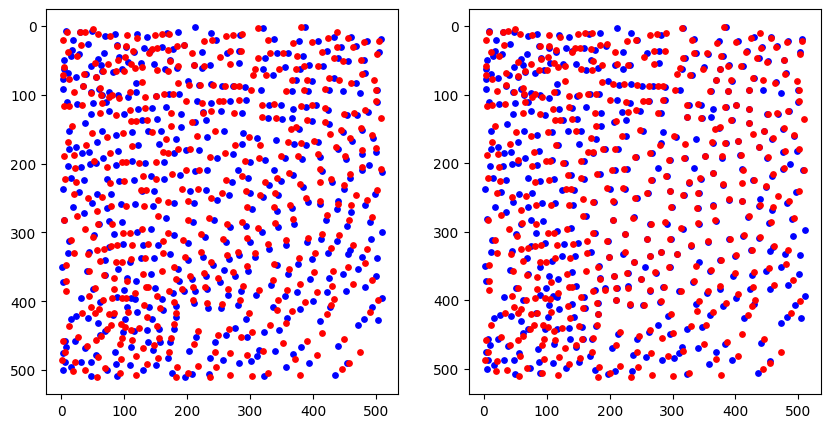

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(image1[:,0],image1[:,1],c='blue',s=15)
plt.scatter(image2[:,0],image2[:,1],c='red',s=15)
plt.gca().invert_yaxis()
plt.subplot(1, 2, 2)
plt.scatter(updated_cooords1[:,0],updated_cooords1[:,1],c='blue',s=15)
plt.scatter(updated_coords2[:,0],updated_coords2[:,1],c='red',s=15)
plt.gca().invert_yaxis()
plt.show()

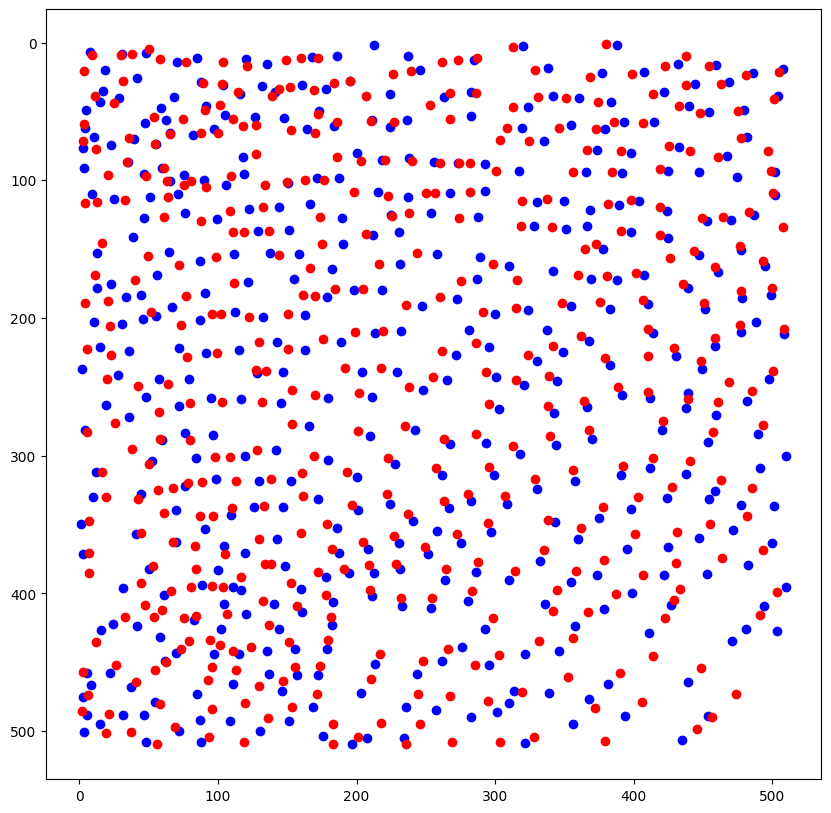

In [5]:
plt.figure(figsize=(10, 10))
plt.scatter(image1[:,0],image1[:,1],c='blue')
plt.scatter(image2[:,0],image2[:,1],c='red')
for particle in updated_coords2:
    if particle[2]<len(image1):
        plt.arrow(image1[int(particle[2])][0],image1[int(particle[2])][1],image2[np.where(updated_coords2==particle[2])[0][0]][0]-image1[int(particle[2])][0],image2[np.where(updated_coords2==particle[2])[0][0]][1]-image1[int(particle[2])][1], head_width=4)
plt.gca().invert_yaxis()
plt.show()

# Tracing feature

In [7]:
def new_tracing(allmatches, original_coords):
    for i in range(2, len(allmatches)):
        min_particle_number = len(allmatches[i - 1])
        matched_particle_ids = allmatches[i][:, 2] < min_particle_number
        unmatched_particle_ids = ~matched_particle_ids

        matched_ids_values = allmatches[i][matched_particle_ids, 2].astype(int)
        matched_id_positions_in_orig = npi.indices(original_coords[i - 1][:, 2], matched_ids_values)

        allmatches[i][matched_particle_ids, 2] = allmatches[i - 1][matched_id_positions_in_orig, 2]

        max_id_number = np.max(allmatches[i - 1][:, 2])
        allmatches[i][unmatched_particle_ids, 2] += max_id_number - min_particle_number + 1

        allmatches[i][:, 2] = allmatches[i][:, 2].astype(int)

    return allmatches

In [118]:
def tracing(allmatches,original_coords): #alles arrays keine dataframes
    
    for i in range(2,len(allmatches)):
        min_particle_number = len(allmatches[i-1]) #max. id number in array before... all lower than that were matched
        matched_particle_ids = np.where(allmatches[i][:,2]<min_particle_number) # id of all matched particles in array i
        unmatched_particle_ids = np.where(allmatches[i][:,2]>=min_particle_number) # id of all unmatched particles in array 
        matched_ids_values = allmatches[i][matched_particle_ids,2][0].astype(int) # ids in i-1 that particles in i are matched to
        #matched_id_positions_in_orig = np.searchsorted(original_coords[i-1][:, 2], matched_ids_values) # positions of matched id particles in original coords1
        matched_id_positions_in_orig = npi.indices(original_coords[i-1][:, 2], matched_ids_values) # positions of matched id particles in original coords1
        #matched_xy = original_coords[i-1][matched_id_positions_in_orig,:2] #original xy coords of all particles, that were matched to in allmatches i-1
        #matched_id_positions = np.where(np.isin(allmatches[i-1][:,0], matched_xy[:,0])&np.isin(allmatches[i-1][:,1], matched_xy[:,1]))[0] #where allmatches i-1 xy coords match the xy coords of the original coords1 at the particle ids that were found matching in allmatches i
        allmatches[i][matched_particle_ids,2] = allmatches[i-1][matched_id_positions_in_orig,2] # update matched particles to ids of particles in i-1
        max_id_number = max(allmatches[i-1][:,2]) #maximum id number of array i-1
        allmatches[i][unmatched_particle_ids,2] += max_id_number - min_particle_number + 1 #add up to id of unmatched particles so the do not double
        allmatches[i][:,2] = allmatches[i][:,2].astype(int)
        
    return allmatches

In [5]:
def convert_to_dataframe(allmatches,starting_image):

    dfs = []
    for frame_number, image_data in enumerate(allmatches, start=starting_image):
        df = pd.DataFrame(image_data, columns=['x', 'y', 'particle_id'])
        df['frame_number'] = frame_number
        dfs.append(df)
    result_df = pd.concat(dfs, ignore_index=True)
    
    return result_df

In [6]:
##old could maybe be deleted
def create_dataframe(coords1,coords2,starting_frame):
    columns = ["x", "y", "particle_id"]
    coords1 = pd.DataFrame(coords1, columns=columns)
    coords1["frame"] = starting_frame
    coords2 = pd.DataFrame(coords2, columns=columns)
    coords2["frame"] = starting_frame+1
    coords1 = pd.concat([coords1, coords2], ignore_index=True)
    return coords1

In [7]:
#### old could maybe be deleted
def add_matched_coords_to_dataframe(dataframe,coords1,coords2,frame_number): #frame number is number of last frame
    columns = ["x", "y", "particle_id"]
    coords1 = pd.DataFrame(coords1, columns=columns)
    coords1["frame"] = frame_number
    coords2 = pd.DataFrame(coords2, columns=columns)
    coords2["frame"] = frame_number
    
    coords2_unmatched = coords2[coords2['particle_id'] >= len(coords1)]
    coords2_unmatched.loc[:,'particle_id'] += (dataframe['particle_id'].max()-coords2_unmatched['particle_id'].min()+1)
    dataframe = pd.concat([dataframe,coords2_unmatched], ignore_index=True)
    
    coords2_matched = coords2[coords2['particle_id'] < len(coords1)]
    for id in coords2_matched.loc[:,'particle_id']:
        particle_coords = coords1[coords1['particle_id']==id]
        x_value = particle_coords['x'].values[0]
        y_value = particle_coords['y'].values[0]
        #matching_rows = dataframe[(dataframe['x'] == x_value) & (dataframe['y'] == y_value) & (dataframe['frame'] == dataframe['frame'].max()-1)]
        matching_rows = dataframe[(dataframe['x'] == x_value) & (dataframe['y'] == y_value)]
        if len(matching_rows)<0:
            particle_coords.loc[:,'particle_id'] = matching_rows['particle_id'].values[0]
            dataframe = pd.concat([dataframe,particle_coords], ignore_index=True)
        else:
            particle_coords.loc[:,'particle_id'] = dataframe['particle_id'].max()+1
            dataframe = pd.concat([dataframe,particle_coords], ignore_index=True)
        
    return dataframe

In [8]:
def dataframe_min_length_filter(dataframe,min_length): #searches for particle ids that appear more then min_length times and filters out all others
    lengths = dataframe['particle_id'].value_counts()
    longer_than_min = lengths[lengths >= min_length]
    filtered_dataframe = dataframe[dataframe['particle_id'].isin(longer_than_min.index)]
    return filtered_dataframe
    

In [9]:
def plot_traces(dataframe):
    grouped_df = dataframe.groupby('particle_id')
    plt.figure(figsize=(10, 10))
    for particle_id, group in grouped_df:
        plt.plot(group['x'], group['y'], label=f'Particle {int(particle_id)}')
    plt.title('Particle Traces')
    plt.gca().invert_yaxis()
    plt.show()


## Anwendung

finished number 1
finished number 2
finished number 3
finished number 4
finished number 5
now tracing


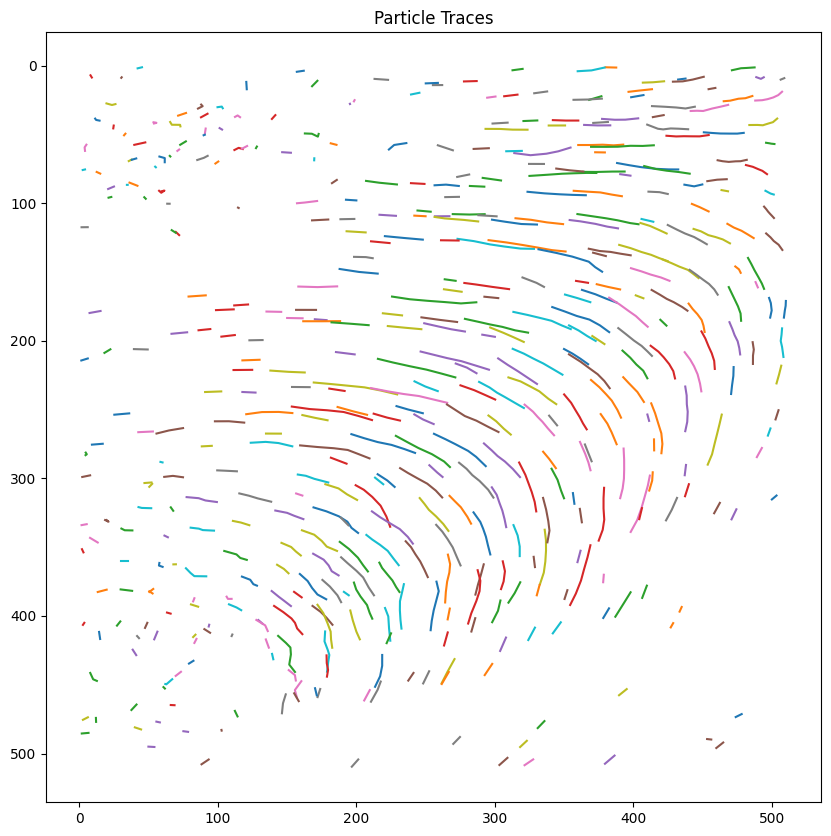

0.884148359298706s for 5 images! 5.655159507354545 fps


In [14]:
##matching und tracing als array
import time

allmatches = np.array((),dtype=object)
original_coords = np.array((),dtype=object)
starting_image = 450
images_to_match = 5
particle_folder = '512positions/'
min_length = 1
start = time.time()
for i in range(images_to_match):
    number_of_image = i + starting_image #370 #220
    filename1 = particle_folder+str(number_of_image)+'.npy'
    filename2 = particle_folder+str(number_of_image+1)+'.npy'
    coords1, coords2 = som.read_in_coordinates(filename1, filename2)
    coords1, coords2 = som.match_particles(coords1, coords2)
    if i==0:
        match = np.array((coords1,coords2),dtype=object)
    else:
        match = np.array([coords2,None],dtype=object)
        match = np.delete(match,1)
    orig_coords = np.array([coords1,None],dtype=object)
    orig_coords = np.delete(orig_coords,1)
    allmatches = np.append(allmatches,match)
    original_coords = np.append(original_coords,orig_coords)
    print(f"finished number {i+1}")
print("now tracing")
allmatches = som.tracing(allmatches,original_coords)
dataframe = som.convert_to_dataframe(allmatches,starting_image)
filtered_particles = som.dataframe_min_length_filter(dataframe,min_length)
som.plot_traces(filtered_particles)
end = time.time()
print(f"{end-start}s for {images_to_match} images! {images_to_match/(end-start)} fps")


finished number 1
finished number 2
finished number 3
finished number 4
finished number 5
now tracing


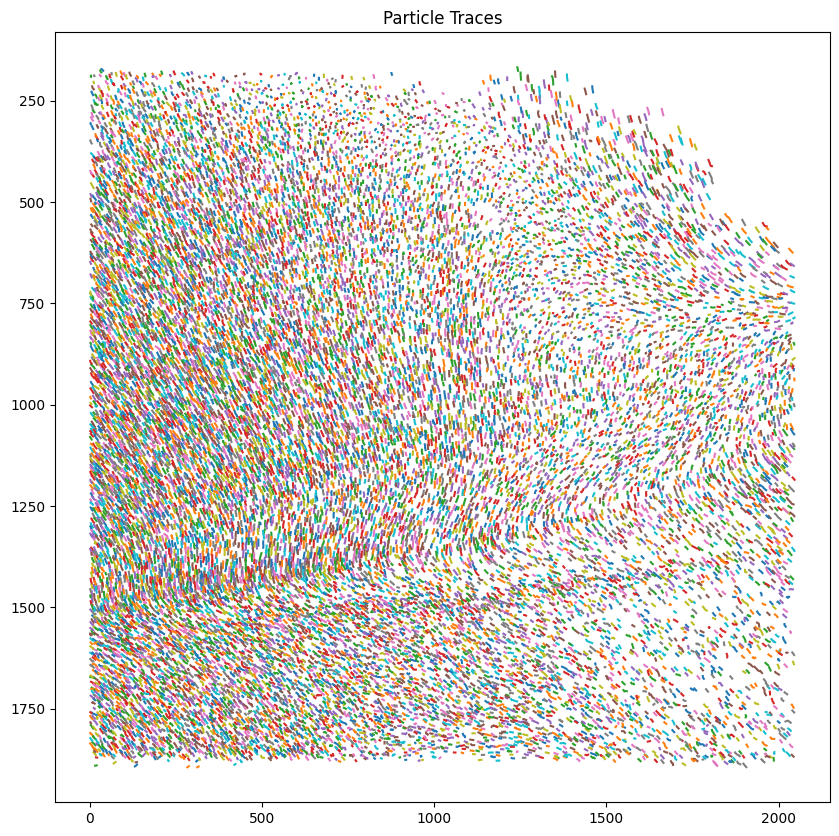

29.40786600112915s for 5 images! 0.1700225375009536 fps


In [53]:
##matching und tracing als array mit großen bildern!
import time

allmatches = np.array((),dtype=object)
original_coords = np.array((),dtype=object)
starting_image = 450
images_to_match = 5
particle_folder = 'big_positions/'
min_length = 3
start = time.time()
for i in range(images_to_match):
    number_of_image = i + starting_image 
    filename1 = particle_folder+'Image_000'+str(number_of_image)+'.npy'
    filename2 = particle_folder+'Image_000'+str(number_of_image+1)+'.npy'
    coords1, coords2 = som.read_in_coordinates(filename1, filename2)
    coords1 = coords1[:, [0, 1, 3]]
    coords2 = coords2[:, [0, 1, 3]]
    coords1, coords2 = som.match_2048_images(coords1, coords2)
    if i==0:
        match = np.array((coords1,coords2),dtype=object)
    elif i>0:
        match = np.array([coords2,None],dtype=object)
        match = np.delete(match,1)
    orig_coords = np.array([coords1,None],dtype=object)
    orig_coords = np.delete(orig_coords,1)
    allmatches = np.append(allmatches,match)
    original_coords = np.append(original_coords,orig_coords)    
    print(f"finished number {i+1}")
print("now tracing")
allmatches = som.tracing(allmatches,original_coords)
dataframe = som.convert_to_dataframe(allmatches,starting_image)
filtered_particles = som.dataframe_min_length_filter(dataframe,min_length)
som.plot_traces(filtered_particles)
end = time.time()
print(f"{end-start}s for {images_to_match} images! {images_to_match/(end-start)} fps")


# Multiprocessing Anwendung

finished image number 1
finished image number 2
finished image number 3
finished image number 4
finished image number 5
finished image number 6
finished image number 7
finished image number 8
finished image number 9
finished image number 10
finished image number 11
finished image number 12
finished image number 13
finished image number 14
finished image number 15
finished image number 16
finished image number 17
finished image number 18
finished image number 19
finished image number 20
finished image number 21
finished image number 22
finished image number 23
finished image number 24
finished image number 25
finished image number 26
finished image number 27
finished image number 28
finished image number 29
finished image number 30
finished image number 31
finished image number 32
finished image number 33
finished image number 34
finished image number 35
finished image number 36
finished image number 37
finished image number 38
finished image number 39
finished image number 40
finished 

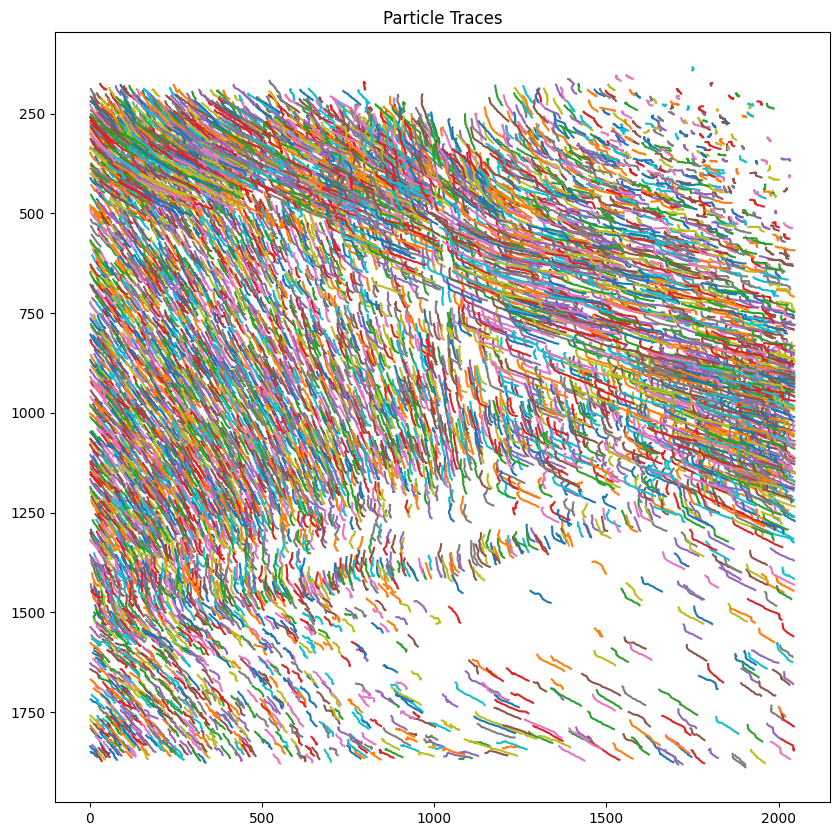

67.25835084915161s for 50 images! 0.7434021109459108 fps


In [25]:
import multiprocessing as mp
import numpy as np
import time

def process_image(image_number, particle_folder):
    filename1 = particle_folder + 'Image_000' + str(image_number) + '.npy'
    filename2 = particle_folder + 'Image_000' + str(image_number + 1) + '.npy'
    coords1, coords2 = som.read_in_coordinates(filename1, filename2)
    coords1 = coords1[:, [0, 1, 3]]
    coords2 = coords2[:, [0, 1, 3]]
    coords1, coords2 = som.match_2048_images(coords1, coords2)
    return coords1, coords2

def main():
    starting_image = 450
    images_to_match = 50
    particle_folder = 'big_positions/'
    min_length = 15
    start = time.time()
    
    # Create a multiprocessing pool
    pool = mp.Pool(mp.cpu_count())
    
    results = []
    for i in range(images_to_match):
        results.append(pool.apply_async(process_image, args=(i + starting_image, particle_folder)))
    
    # Get the results in the correct order
    #allmatches = []
    #original_coords = []
    allmatches = np.array((),dtype=object)
    original_coords = np.array((),dtype=object)
    #for result in results:
    for i, result in enumerate(results):
        coords1, coords2 = result.get()
        if i==0:
            match = np.array((coords1,coords2),dtype=object)
        elif i>0:
            match = np.array([coords2,None],dtype=object)
            match = np.delete(match,1)
        orig_coords = np.array([coords1,None],dtype=object)
        orig_coords = np.delete(orig_coords,1)
        allmatches = np.append(allmatches,match)
        original_coords = np.append(original_coords,orig_coords)    
        #allmatches.append((coords1, coords2))
        #original_coords.append(coords1)
        print(f"finished image number {i+1}")
    
    pool.close()
    pool.join()
    
    print("now tracing")
    # Perform tracing and further processing
    allmatches = som.tracing(allmatches, original_coords)
    dataframe = som.convert_to_dataframe(allmatches, starting_image)
    filtered_particles = som.dataframe_min_length_filter(dataframe, min_length)
    som.plot_traces(filtered_particles)
    
    end = time.time()
    print(f"{end-start}s for {images_to_match} images! {images_to_match/(end-start)} fps")

if __name__ == "__main__":
    main()


# Comparison old SOM

In [174]:
import time
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import math
import circle_fit as cf
from PIL import Image
from IPython.display import clear_output
%matplotlib inline

In [175]:
import SOMacc  #Use only SOM if numba not installed 

In [176]:
starting_image = 450
images_to_match = 20
image_size = 512

In [177]:
folder = "512positions/"
dmax = 8.96/image_size
alpha = 0.011
cycles = 5
startradius = 128 / image_size 
finalradius = 0.0128 / image_size
epsilon = 10.24/image_size 
plot = "no" #"yes"/"no"
output = "matches" #"percentage"/"matches"/"no"
min_length = 3

In [178]:
##only matching

start = time.time()
allmatches = []

for i in range(images_to_match-1):
    a = np.load(folder+str(i + starting_image)+".npy")
    b = np.load(folder+str(i + starting_image+1)+".npy")
    #a = np.load(folder+'Image_000'+str(i + starting_image)+".npy")[:,:2]
    #b = np.load(folder+'Image_000'+str(i + starting_image+1)+".npy")[:,:2]
    #clear_output(wait=True)
    matches = SOMacc.som(a,b,cycles,startradius,finalradius,alpha,image_size,epsilon,plot,output,dmax)
    print("Finished image "+str(i+2)+"/"+str(images_to_match))
    allmatches.append(matches)
#clear_output(wait=True)
#coords = SOMacc.traces_to_coords(SOMacc.alltracing(allmatches,min_length),starting_image,image_size,folder)
#SOMacc.plotting_coords(coords)
end = time.time()
print(end-start)

Finished image 2/20
Finished image 3/20
Finished image 4/20
Finished image 5/20
Finished image 6/20
Finished image 7/20
Finished image 8/20
Finished image 9/20
Finished image 10/20
Finished image 11/20
Finished image 12/20
Finished image 13/20
Finished image 14/20
Finished image 15/20
Finished image 16/20
Finished image 17/20
Finished image 18/20
Finished image 19/20
Finished image 20/20
3.0548832416534424


Finished image 2/20
Finished image 3/20
Finished image 4/20
Finished image 5/20
Finished image 6/20
Finished image 7/20
Finished image 8/20
Finished image 9/20
Finished image 10/20
Finished image 11/20
Finished image 12/20
Finished image 13/20
Finished image 14/20
Finished image 15/20
Finished image 16/20
Finished image 17/20
Finished image 18/20
Finished image 19/20
Finished image 20/20
1.9933409690856934


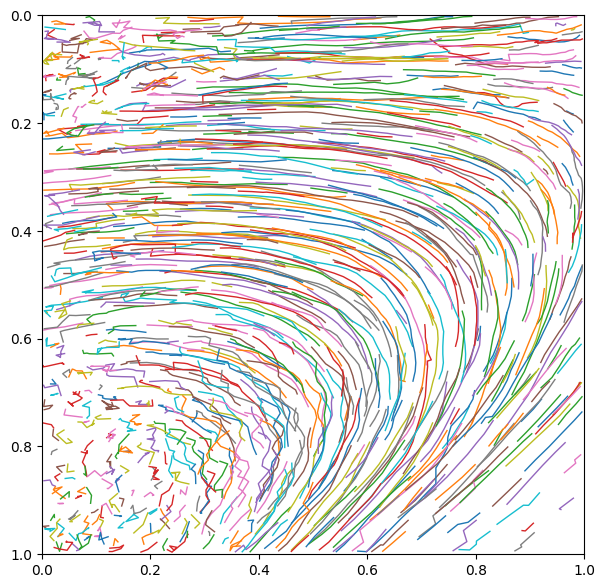

In [179]:
##matching and tracing

start = time.time()
allmatches = []

for i in range(images_to_match-1):
    a = np.load(folder+str(i + starting_image)+".npy")
    b = np.load(folder+str(i + starting_image+1)+".npy")
    #a = np.load(folder+'Image_000'+str(i + starting_image)+".npy")[:,:2]
    #b = np.load(folder+'Image_000'+str(i + starting_image+1)+".npy")[:,:2]
    #clear_output(wait=True)
    matches = SOMacc.som(a,b,cycles,startradius,finalradius,alpha,image_size,epsilon,plot,output,dmax)
    print("Finished image "+str(i+2)+"/"+str(images_to_match))
    allmatches.append(matches)
#clear_output(wait=True)
coords = SOMacc.traces_to_coords(SOMacc.alltracing(allmatches,min_length),starting_image,image_size,folder)
SOMacc.plotting_coords(coords)
end = time.time()
print(end-start)

In [10]:
particle_folder = '512positions/'
#filename1 = particle_folder+'Image_000450.npy'
#filename2 = particle_folder+'Image_000451.npy'
filename1 = particle_folder+'450.npy'
filename2 = particle_folder+'451.npy'

In [16]:
start = time.time()
for _ in range(50):
    coords1, coords2 = som.read_in_coordinates(filename1, filename2)
    image1 = np.copy(coords1)
    image2 = np.copy(coords2)
    updated_cooords1, updated_coords2 = som.iterated_weight_update(coords1, coords2)
    end = time.time()
print(end-start)

1.6954214572906494


In [17]:
start = time.time()
for _ in range(50):
    coords1, coords2 = som.read_in_coordinates(filename1, filename2)
    image1 = np.copy(coords1)
    image2 = np.copy(coords2)
    coords1, coords1 = som.match_particles(coords1, coords2)
    end = time.time()
print(end-start)

1.7466764450073242


# Split large coords into 16 areas

In [47]:
distance_threshold = 10
alpha = .004#.04 #512:.04 eher .04
startradius = 80 #40-100
endradius = 1
iterations = 5 #resized:5, 512:10
epsilon = 4
som = SOM(distance_threshold, alpha, startradius, endradius, iterations, epsilon)

In [48]:
# time with old som on cluster pc: 258.79403734207153
start = time.time()
particle_folder = 'big_positions/'
filename1 = particle_folder+'Image_000450.npy'
filename2 = particle_folder+'Image_000451.npy'
coords1, coords2 = som.read_in_coordinates(filename1, filename2)
coords1 = coords1[:, [0, 1, 3]]
coords2 = coords2[:, [0, 1, 3]]
coords1, coords2 = som.match_2048_images(coords1, coords2)
end = time.time()
print(end-start)

4.284242868423462


In [7]:
i = 0
for particle in coords2:
    if particle[2] in coords1[:,2]:
        i+=1
i*100/len(coords1)

83.89324272483148

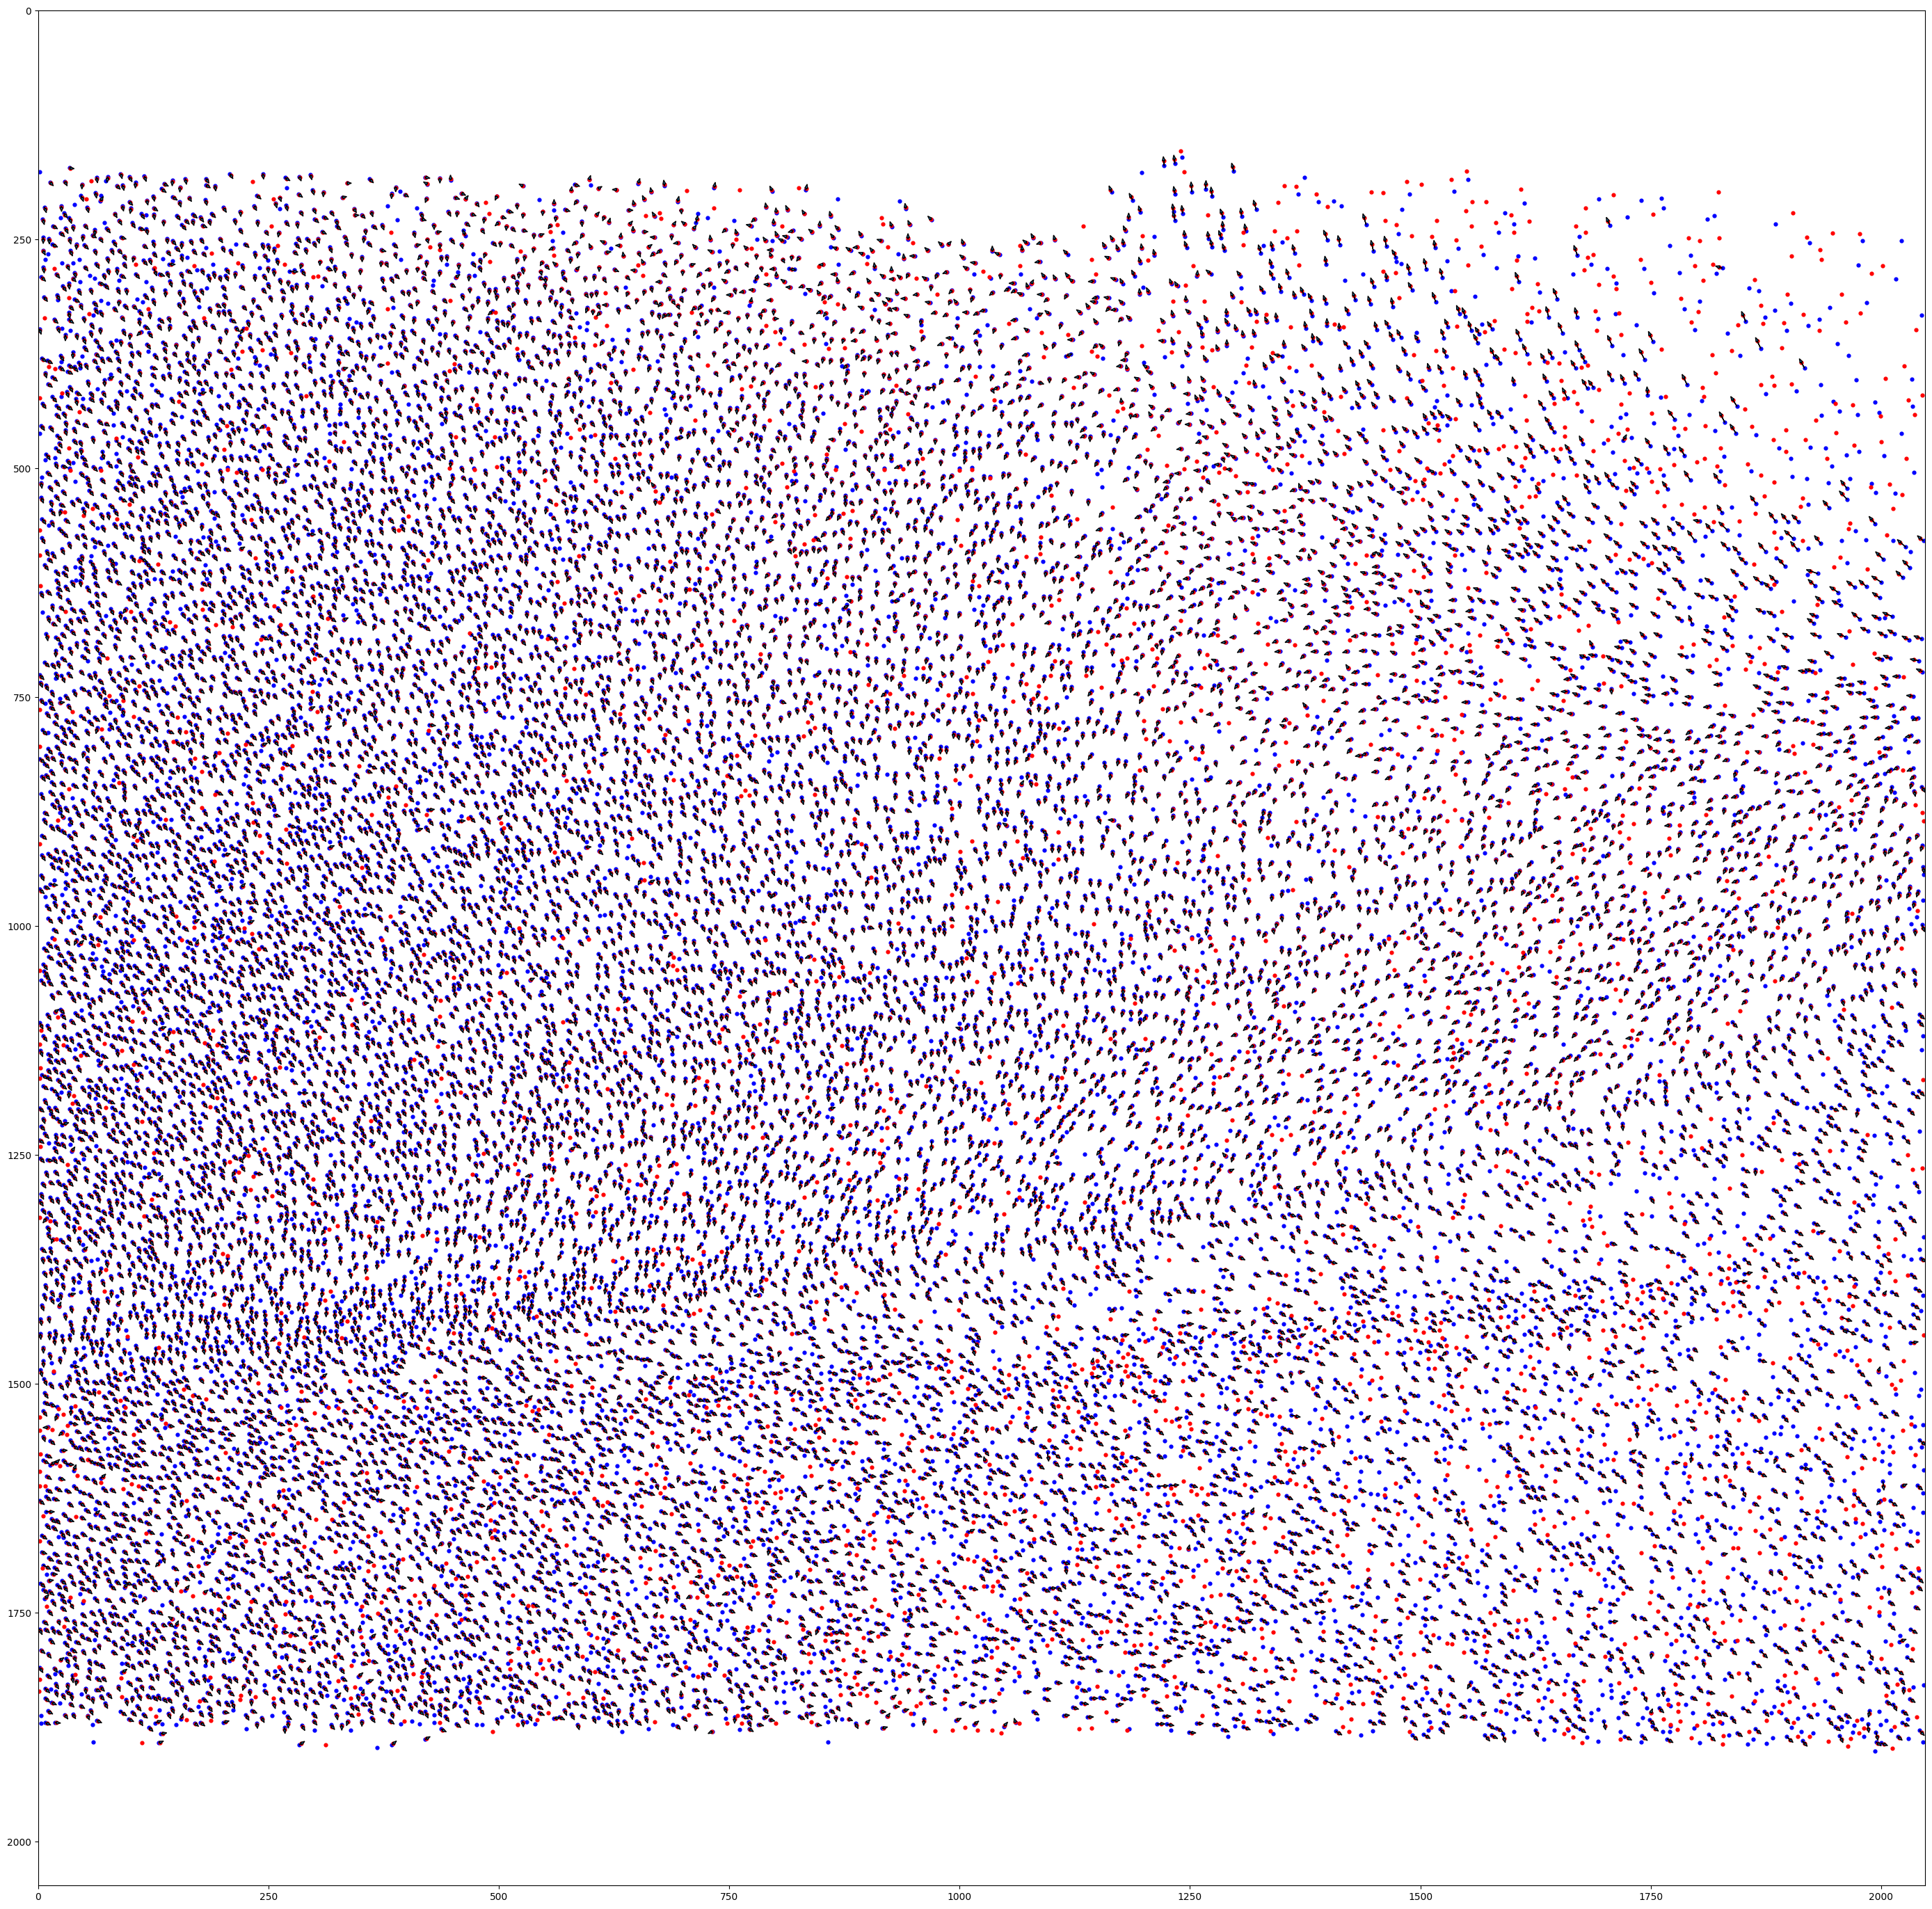

15308


In [9]:
#plot everything for reassurance
plt.figure(figsize=(35, 35))
plt.scatter(coords1[:,0],coords1[:,1],c='blue',s=12)
plt.scatter(coords2[:,0],coords2[:,1],c='red',s=12)
i = 0
for particle in coords2:
    if particle[2] in coords1[:,2]:
        i+=1
        coords1_id = np.where(coords1[:,2]==particle[2])[0][0]
        coords2_id = np.where(coords2[:,2]==particle[2])[0][0]
        plt.arrow(coords1[coords1_id][0],coords1[coords1_id][1],coords2[coords2_id][0]-coords1[coords1_id][0],coords2[coords2_id][1]-coords1[coords1_id][1], head_width=3)
plt.xlim(0, 2048)  # Set x-axis limits
plt.ylim(0, 2048)  # Set y-axis limits
plt.gca().invert_yaxis()
plt.show()
print(i)
plt.close()


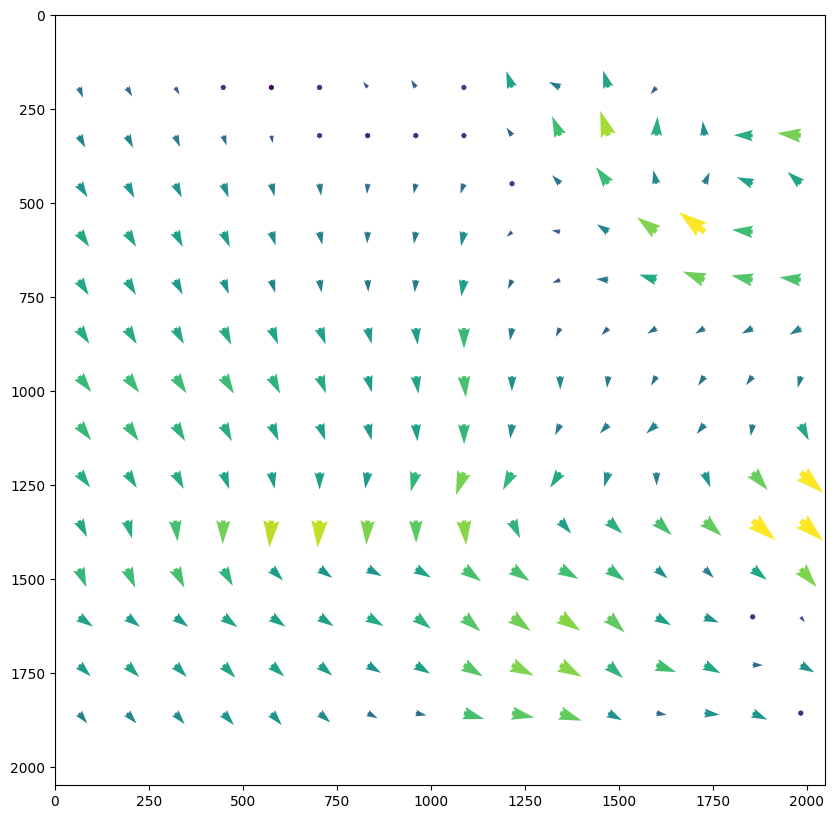

4.852548122406006


In [23]:
# time with old som on cluster pc: 258.79403734207153
start = time.time()
particle_folder = 'big_positions/'
filename1 = particle_folder+'Image_000450.npy'
filename2 = particle_folder+'Image_000452.npy'
coords1, coords2 = som.read_in_coordinates(filename1, filename2)
coords1 = coords1[:, [0, 1, 3]]
coords2 = coords2[:, [0, 1, 3]]
coords1, coords2 = som.match_2048_images(coords1, coords2)
som.quiver_plot(coords1,coords2,16)
end = time.time()
print(end-start)

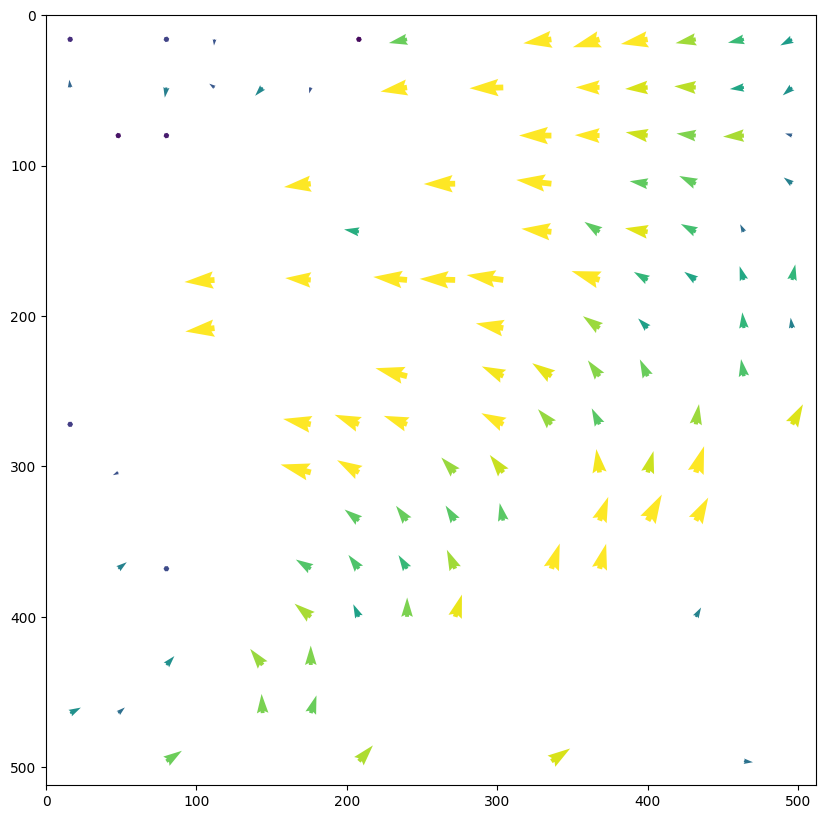

0.2302265167236328


In [27]:
start = time.time()
particle_folder = '512positions/'
filename1 = particle_folder+'450.npy'
filename2 = particle_folder+'451.npy'
coords1, coords2 = som.read_in_coordinates(filename1, filename2)
coords1, coords2 = som.match_particles(coords1, coords2)
som.quiver_plot(coords1,coords2,number_of_boxes=16,image_size=512,scale=0.5)
end = time.time()
print(end-start)

In [90]:
particles00,particles01,particles02,particles03,particles10,particles11,particles12,particles13,particles20,particles21,particles22,particles23,particles30,particles31,particles32,particles33 = som.sort_2048_coords_in_16_boxes(coords1)
particles00_second,particles01_second,particles02_second,particles03_second,particles10_second,particles11_second,particles12_second,particles13_second,particles20_second,particles21_second,particles22_second,particles23_second,particles30_second,particles31_second,particles32_second,particles33_second = som.sort_2048_coords_in_16_boxes(coords2)

image00,image01,image02,image03,image10,image11,image12,image13,image20,image21,image22,image23,image30,image31,image32,image33 = np.copy(particles00),np.copy(particles01),np.copy(particles02),np.copy(particles03),np.copy(particles10),np.copy(particles11),np.copy(particles12),np.copy(particles13),np.copy(particles20),np.copy(particles21),np.copy(particles22),np.copy(particles23),np.copy(particles30),np.copy(particles31),np.copy(particles32),np.copy(particles33)
image00_second,image01_second,image02_second,image03_second,image10_second,image11_second,image12_second,image13_second,image20_second,image21_second,image22_second,image23_second,image30_second,image31_second,image32_second,image33_second = np.copy(particles00_second),np.copy(particles01_second),np.copy(particles02_second),np.copy(particles03_second),np.copy(particles10_second),np.copy(particles11_second),np.copy(particles12_second),np.copy(particles13_second),np.copy(particles20_second),np.copy(particles21_second),np.copy(particles22_second),np.copy(particles23_second),np.copy(particles30_second),np.copy(particles31_second),np.copy(particles32_second),np.copy(particles33_second)
        

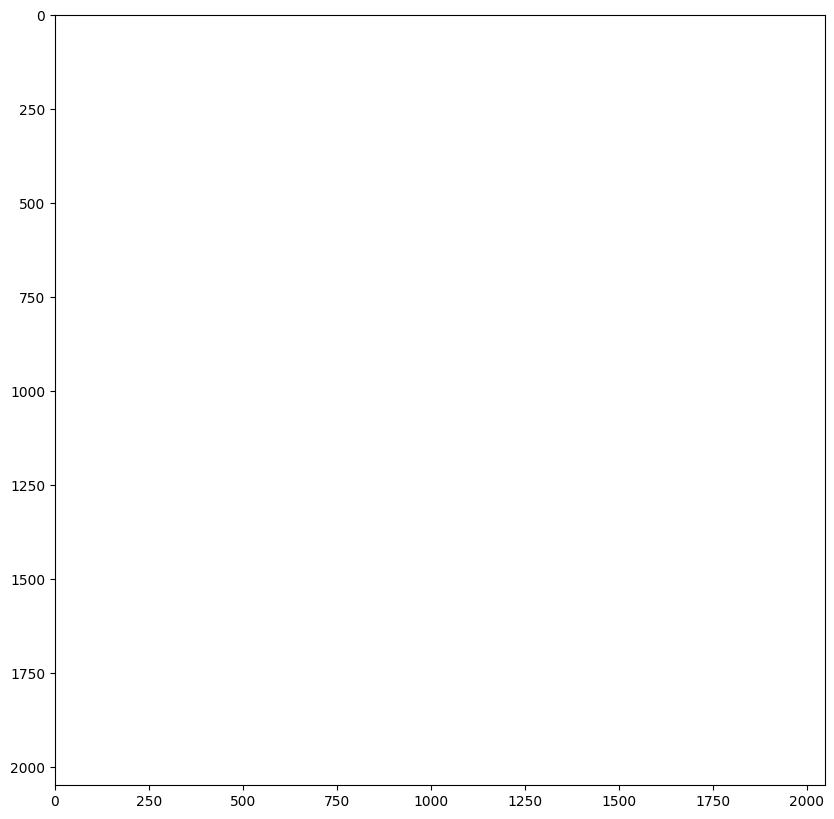

0.12176513671875


In [93]:
# time with old som on cluster pc: 258.79403734207153
start = time.time()
particle_folder = 'big_positions/'
filename1 = particle_folder+'Image_000050.npy'
filename2 = particle_folder+'Image_000051.npy'
coords1, coords2 = som.read_in_coordinates(filename1, filename2)
coords1 = coords1[:, [0, 1, 3]]
coords2 = coords2[:, [0, 1, 3]]
coords1, coords2 = som.match_2048_images(coords1, coords2)
som.quiver_plot(coords1,coords2,16)
end = time.time()
print(end-start)

In [91]:
image02[:,2]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [92]:
som.match_particles(particles03, particles03_second)


(array([1529.75      ,  172.66666667,    0.        ]),
 array([1.5305e+03, 1.7360e+02, 1.0000e+00]))